# Customer Segmentation Using Clustering

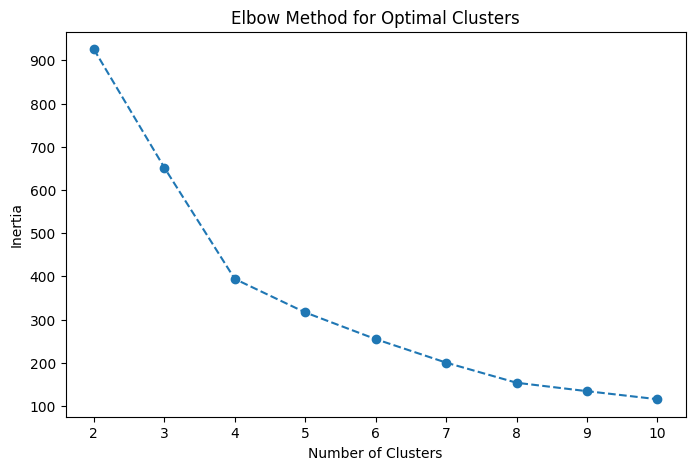

Davies-Bouldin Index: 0.7549


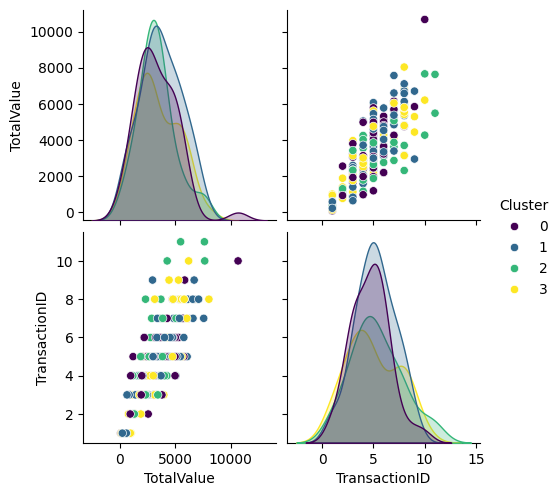

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Aggregate transaction data for customer profiling
customer_features = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count'  # Number of transactions
}).reset_index()

# Merge with customer profile data
customer_data = customer_features.merge(customers, on='CustomerID', how='left')

# Encode categorical variables (Region)
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_data[['Region']]).toarray()

# Combine encoded data with numerical data
features = pd.concat(
    [customer_data[['TotalValue', 'TransactionID']],
     pd.DataFrame(encoded_region, index=customer_data.index,
                  columns=[f'Region_{i}' for i in range(encoded_region.shape[1])])], # Assign string column names to encoded region features
    axis=1
)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Choose optimal number of clusters and fit KMeans
optimal_clusters = 4  # Choose based on Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Visualizing Clusters using Pairplot
sns.pairplot(customer_data, hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()
